<a href="https://colab.research.google.com/github/min0j98/mobis_aistudy_2023/blob/master/DL_07_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %tensorflow_version 2.x
## load modules
import cv2 as cv
import matplotlib.pyplot as plt
import os, time
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
print(tf.__version__)

2.14.0


In [2]:
!git clone https://github.com/min0j98/mobis_aistudy_2023.git

Cloning into 'mobis_aistudy_2023'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 78 (delta 21), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (78/78), 3.32 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [3]:
!mkdir -p ./data_1000
!unzip '/content/mobis_aistudy_2023/sdl_Data_1000.zip' -d data_1000

Archive:  /content/mobis_aistudy_2023/sdl_Data_1000.zip
 extracting: data_1000/35.4527.jpg   
 extracting: data_1000/35.4561.jpg   
 extracting: data_1000/35.4579.jpg   
 extracting: data_1000/35.4595.jpg   
 extracting: data_1000/35.4617.jpg   
 extracting: data_1000/35.4625.jpg   
 extracting: data_1000/35.4637.jpg   
 extracting: data_1000/35.4644.jpg   
 extracting: data_1000/35.4668.jpg   
 extracting: data_1000/35.4674.jpg   
 extracting: data_1000/35.4681.jpg   
 extracting: data_1000/35.4754.jpg   
 extracting: data_1000/35.4787.jpg   
 extracting: data_1000/35.4796.jpg   
 extracting: data_1000/35.4853.jpg   
 extracting: data_1000/35.4893.jpg   
 extracting: data_1000/35.4994.jpg   
 extracting: data_1000/35.5084.jpg   
 extracting: data_1000/35.5102.jpg   
 extracting: data_1000/35.5113.jpg   
 extracting: data_1000/35.5141.jpg   
 extracting: data_1000/35.5254.jpg   
 extracting: data_1000/35.5281.jpg   
 extracting: data_1000/35.5315.jpg   
 extracting: data_1000/35.5316.j

In [4]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_1000/'
img_size = 56       # 이미지 사이즈
channels = 1
noise_dim = 100
#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img
def get_data():
    #src 경로에 있는 파일 명을 저장합니다.
    files = os.listdir(src)
    X = []

    # 경로와 파일명을 입력으로 넣어 확인하고
    # 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.

    for file in files:

        X.append((img_read(src,file)-127.5)/127.5)


    # Train set(80%), Test set(20%)으로 나누기
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # (x, 56, 56, 1) 차원으로 맞춰줌
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)


    return X_train, X_test

# 데이터 셋 불러옴 (이미지만 필요해서 y 라벨 필요 없음)
X_train, X_test = get_data()
print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (800, 56, 56, 1)
X_test.shape = (200, 56, 56, 1)


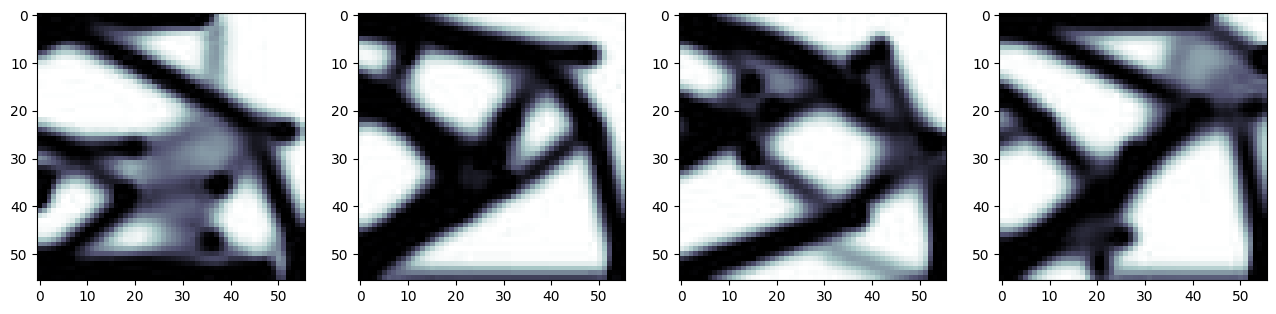

In [5]:
# images 확인용
fig = plt.figure(figsize=(20,10))
nplot = 5
for i in range(1,nplot):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, :, :, 0],cmap = plt.cm.bone)
plt.show()

In [6]:
# ---------------------
#  Generator 모델 구성 (input : noise / output : image)
# ---------------------

def build_generator():
    model = Sequential()

    model.add(layers.Dense(256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(56*56), activation='tanh'))
    model.add(layers.Reshape((56,56,1)))
    # noise 텐서 생성, model에 noise 넣으면 이미지 나옴
    noise = Input(shape=(100,))
    img = model(noise)
    model.summary()
    return Model(noise,img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25600     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

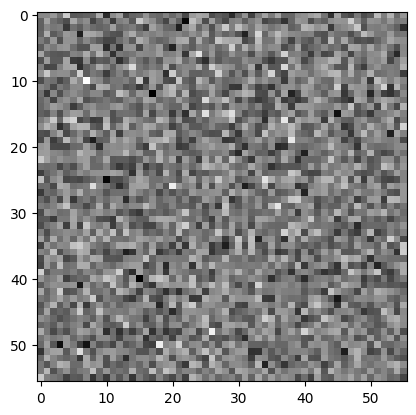

In [7]:
# Optimizer
optimizer =tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

# generator 모델 생성과 컴파일(loss함수와 optimizer 설정)
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# 노이즈 만들어서 generator에 넣은 후 나오는 이미지 출력 (확인용)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# plot_model(generator, show_shapes=True)

In [8]:
# ---------------------
#  Discriminator 모델 구성 (input : image / output : 판별값(0에서 1사이의 숫자))
# ---------------------
def build_discriminator():
    model = tf.keras.Sequential()
    img_shape = (img_size, img_size, channels)
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    # 이미지 들어갈 텐서 생성, model에 넣으면 판별값 나옴
    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [9]:
# discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics   = ['accuracy'])

# image를 discriminator에 넣었을 때 판별값 나옴 (예시. 확인용)
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1737729 (6.63 MB)
Trainable params: 1737

In [10]:
# Combined Model
# 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 discriminator가 분류.

z = layers.Input(shape=(100,), name="noise_input")
img = generator(z)

# 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
discriminator.trainable = False

# discriminator에 이미지를 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
valid = discriminator(img)

# generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
# discriminator를 속이도록 generator를 학습
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise_input (InputLayer)    [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 56, 56, 1)         3904064   
                                                                 
 model_1 (Functional)        (None, 1)                 1737729   
                                                                 
Total params: 5641793 (21.52 MB)
Trainable params: 3900480 (14.88 MB)
Non-trainable params: 1741313 (6.64 MB)
_________________________________________________________________


In [11]:
def train(epochs, batch_size=128, sample_interval=50):

        # 정답으로 사용 할 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise 생성(batch_size만큼)
            noise = np.random.normal(0, 1, (batch_size, 100))

            # noise를 generator에 넣어서 fake image 이미지 생성
            gen_imgs = generator.predict(noise)

            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가
            # 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # noise 생성
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # noise가 들어가서 discriminator가 real image라고 판단하도록 generator를 학습
            g_loss = combined.train_on_batch(noise, valid)

            history.append({"D":d_loss[0],"G":g_loss})

            # sample_interval(1000) epoch 마다 loss와 accuracy와 이미지 출력
            if epoch % sample_interval == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                sample_images(epoch)
        return(history)

In [12]:
 # 이미지 출력
def sample_images(epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, noise_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap=plt.cm.bone)
                axs[i,j].axis('off')
                cnt += 1
#             fig.savefig("images/%d.png" % epoch)
#         plt.close()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 32ms/step
6000 [D loss: 0.183578, acc.: 92.19%] [G loss: 5.693379]
1/1 [==============================] - 0s 29ms/step
7000 [D loss: 0.074877, acc.: 96.88%] [G loss: 4.744594]
1/1 [==============================] - 0s 29ms/step
8000 [D loss: 0.030858, acc.: 98.44%] [G loss: 6.184731]
1/1 [==============================] - 0s 33ms/step
9000 [D loss: 0.028228, acc.: 98.44%] [G loss: 5.869089]
1/1 [==============================] - 0s 28ms/step
10000 [D loss: 0.039779, acc.: 98.44%] [G loss: 6.334688]
1/1 [==============================] - 0s 31ms/step


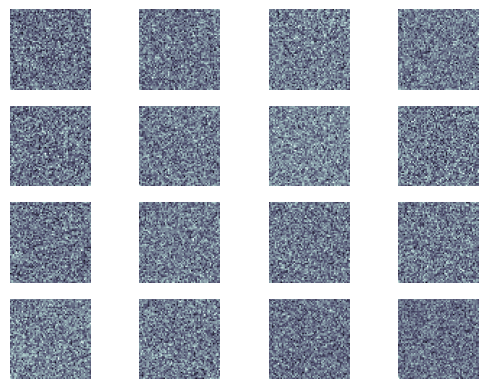

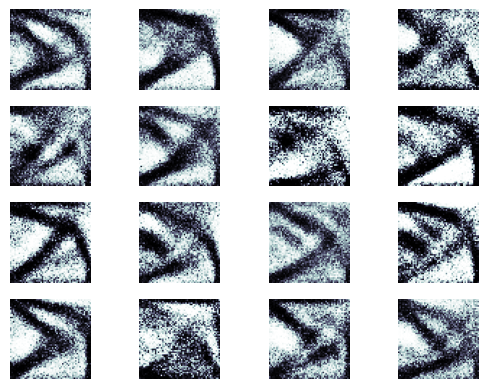

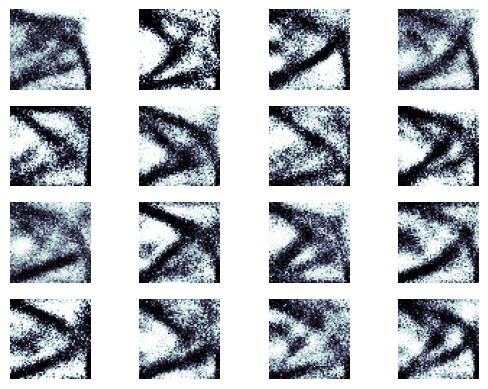

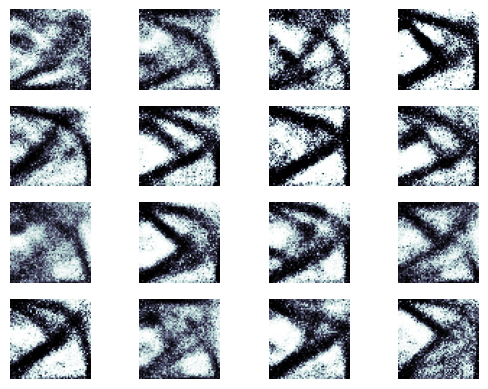

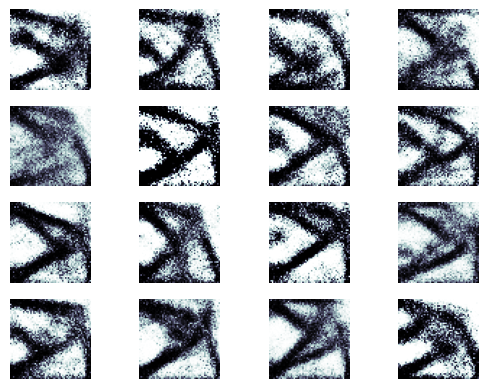

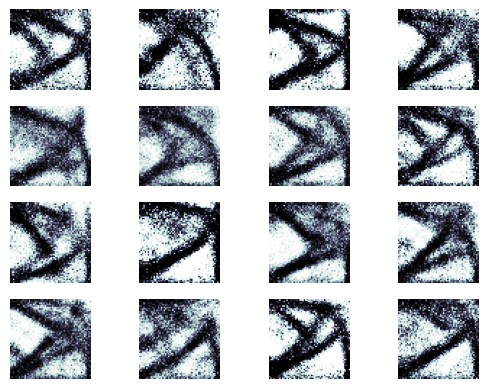

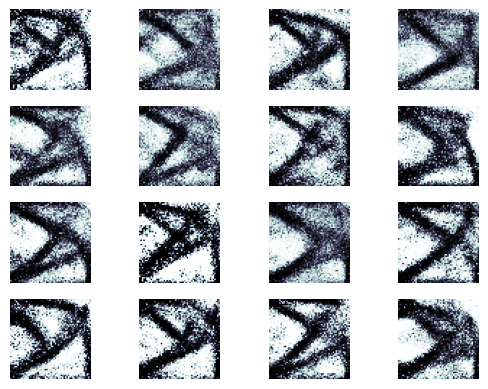

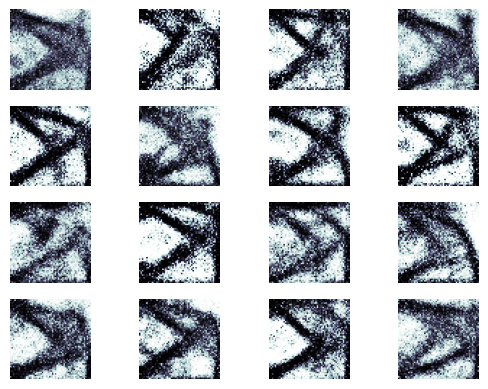

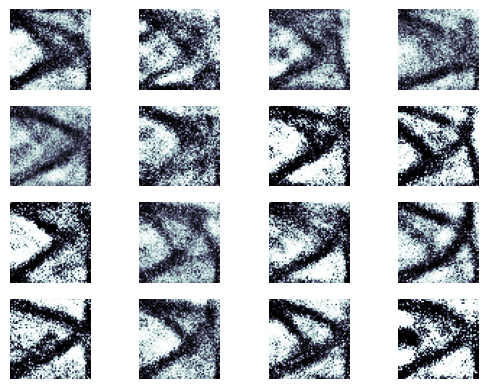

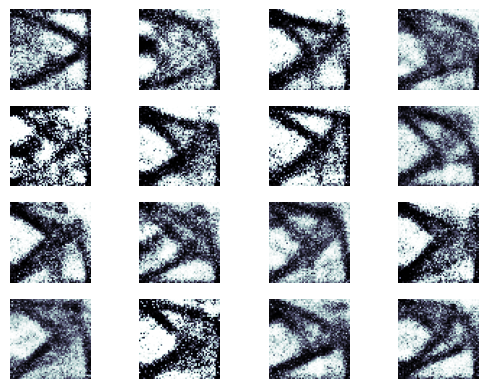

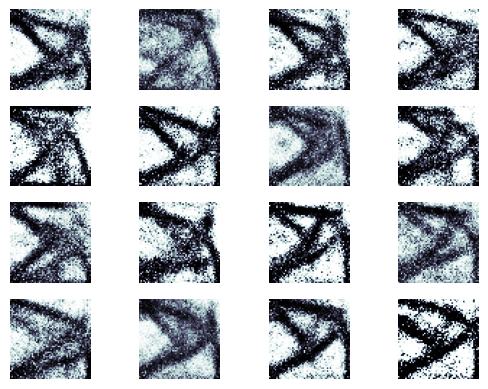

In [13]:
# GAN 실행
history=train(epochs=10001, batch_size=32, sample_interval=1000)

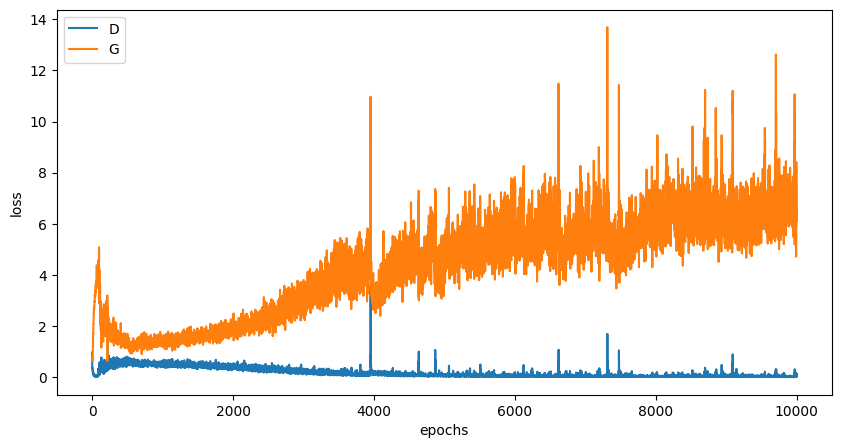

In [14]:
# summarize history for loss
import pandas as pd
hist = pd.DataFrame(history)
plt.figure(figsize=(10,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

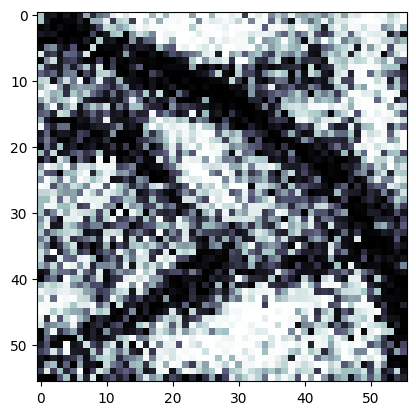

In [15]:
generated_image = generator(tf.random.normal([1, noise_dim]))
plt.imshow(tf.reshape(generated_image, shape = (56,56)), cmap=plt.cm.bone)